# Basic Example
___


In [1]:
import hostphot
print('HostPhot version:', hostphot.__version__)

HostPhot version: 3.0.0


___
## Cutouts

This module allows you to download image cutouts from several surveys. For this, the user can use the ``download_images()`` function with the coordinates of an object:

In [2]:
from hostphot.cutouts import download_images

name = 'SN2004eo'
ra, dec =  308.22579, 9.92853
host_ra, host_dec = 308.2092, 9.92755  # coords of host galaxy
z = 0.0157  # redshift
survey = 'PS1'
download_images(name, host_ra, host_dec, survey=survey)

A new directory is created with the ``name`` and ``survey`` under the working directory (see :ref:`Working Directory <work_dir>`). The downloaded fits images will have the format ``<survey>_<filter>.fits``. If the filters are not specified, images in all the available filters (survey dependent) are downloaded. It is recommended to use the coordinates of the host galaxy to have it in the centre of the image. Sometimes, the transient can be very far from the host galaxy, so having separate images for the object and its host might be better.

Let's check the downloaded image:

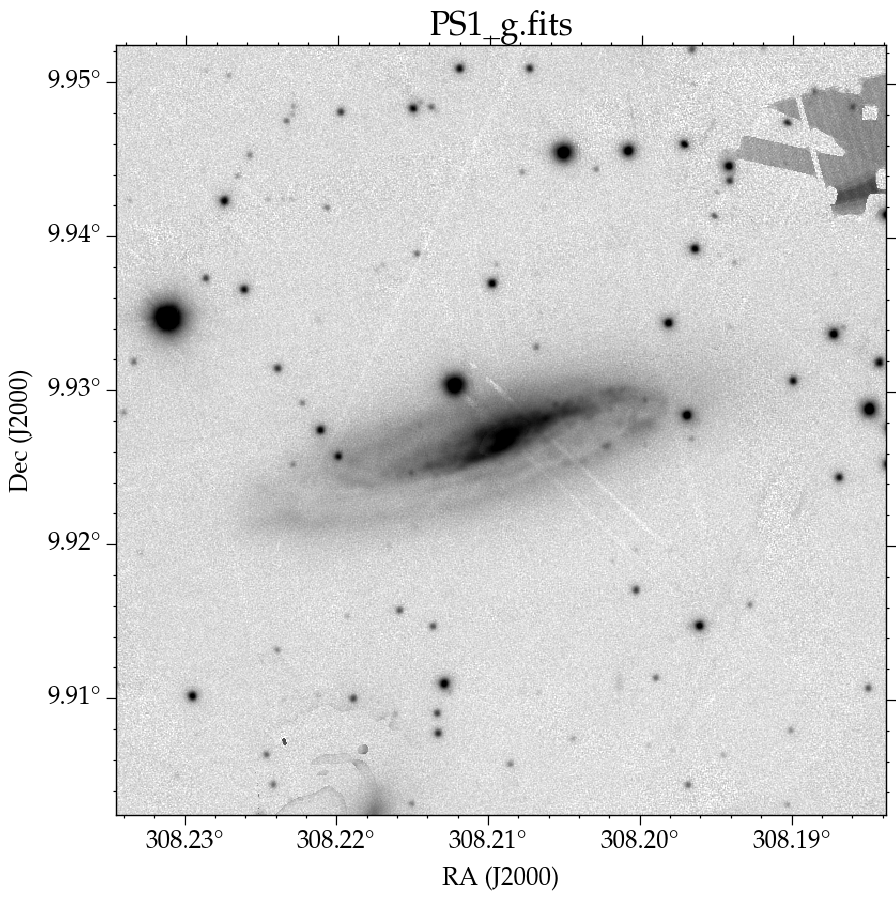

In [3]:
from hostphot.utils import plot_fits

plot_fits('images/SN2004eo/PS1/PS1_g.fits')

___
## Image Processing

A set of pre-processing steps can be performed to ensure an accurate photometry calculation. Note that all the steps are performed following the structure given by the working directory (see :ref:`Working Directory <work_dir>`).

### Coadding

In [4]:
from hostphot.processing import coadd_images

coadd_filters = 'riz'
coadd_images(name, filters=coadd_filters, survey=survey)  # creates a new fits file

This creates a new fits image under the object's directory, in this case, with the name ``PS1_riz.fits``. Coadding images is useful for common aperture photometry (see below). For the coadd, HostPhot makes use of `reproject <https://reproject.readthedocs.io/en/stable/index.html>`_.

### Masking

Some low-redshift galaxy can have foreground stars "sitting" on top of them. HostPhot can remove these first detecting them with pseudo-sigma clipping (using `sep <https://github.com/kbarbary/sep/>`_) and cross-matching the sources with a catalog of stars (using `astroquery MAST <https://astroquery.readthedocs.io/en/latest/mast/mast.html>`_), and then masking them using a 2D Gaussian kernel. The coadded image created above can be masked and the parameters of the mask can be extracted to be used on single filter images of the same object: 

In [5]:
from hostphot.processing import create_mask

# one can extract the mask parameters from the coadd
# this also creates new fits files
create_mask(name, host_ra, host_dec,
            filt=coadd_filters, survey=survey,
            threshold=23,
            ra=ra, dec=dec, save_plots=True, save_mask_params=True)

In [6]:
for filt in 'grizy':
    create_mask(name, host_ra, host_dec, filt, survey=survey,
                ra=ra, dec=dec, ref_filt=coadd_filters, 
                ref_survey=survey, save_plots=False, save_input=False)

Note that the host-galaxy coordinates need to be provided so HostPhot knows which object not to mask out. The SN coordinates are optional to plot its position. The steps above create masked fits images, in this case, with the names ``PS1_<filter>_masked.fits``. See below an example of this mask applied:

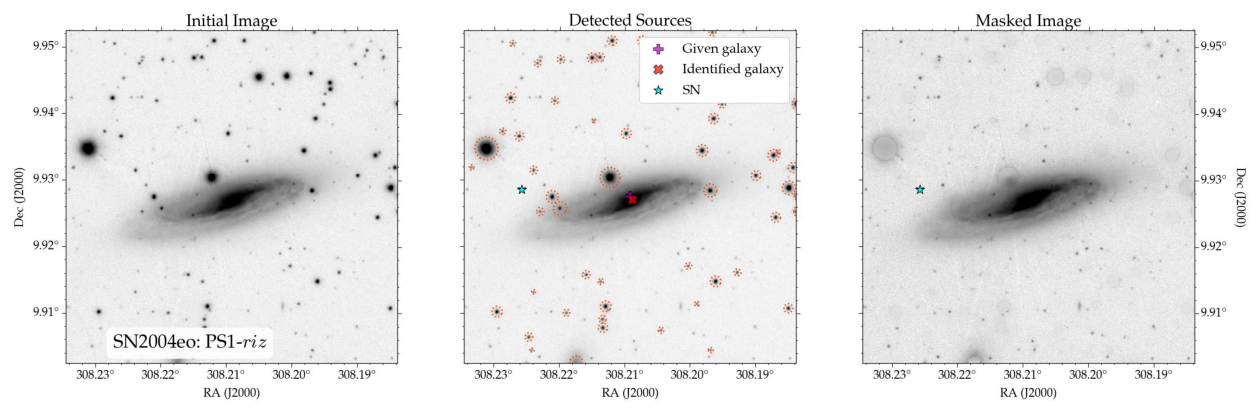

In [7]:
from hostphot.utils import plot_image

plot_image('images/SN2004eo/PS1/PS1_riz_masked.jpg')

If the user is not happy with the result of the masking, there are a few parameters that can be adjusted. For instance, ``threshold`` sets the threshold (how many sigmas above the background noise) used by ``sep`` for detecting objects. Lowering it will allow the detection of fainter objects. ``sigma`` is the width of the gaussian used for convolving the image and masking the detected objects. If ``crossmatch`` is set to ``True``, the detected objects are cross-matched with the Gaia catalog and only those in common are kept. This is useful for very nearby host galaxies (e.g. that of SN 2011fe) so the structures of the galaxy are not maked out, artificially lowering its flux. Note that the images can be background subtracted by setting ``bkg_sub=True``, although this is already performed by default for the surveys that need it.

___
## Photometry

HostPhot can calculate the photometry of the entire galaxy (global) or in a given circular aperture (local). For this, the code heavily relies on astropy and photutils. Note that the only surveys that need background subtraction are 2MASS, WISE and VISTA, which is performed by default.

### Local Photometry

Local photometry can be obtained for the downloaded images. For this, a circular aperture is used (multiple apertures can be set), assuming a cosmology (``H0=70`` and ``Om0=0.3`` by default; hence a redshift is needed):

In [8]:
from hostphot.photometry import local_photometry as lp

ap_radii = [3, 4]  # aperture radii in units of kpc
results = lp.multi_band_phot(name, ra, dec, z,
                             survey=survey, ap_radii=ap_radii,
                             use_mask=True, correct_extinction=True,
                             save_plots=False, save_results=True)

``results`` is a pandas DataFrame with the photometry (flux and magnitudes) of the filters used (the results are saved into a CSV file). Note that the coordinates are at the position of the object (``SN2004eo``). The cosmology can be changed with :func:`lp.choose_cosmology()`. Setting ``use_mask=True`` tells HostPhot to used the masked images previously created (see :ref:`Image Pre-processing <preprocessing>`) and setting ``save_plots=True`` provides output plots with the images and the apertures used, which are saved under the object's directory.

In [9]:
results

,name,ra,dec,redshift,survey,g_3,g_3_err,g_3_flux,g_3_flux_err,g_4,...,z_zeropoint,y_3,y_3_err,y_3_flux,y_3_flux_err,y_4,y_4_err,y_4_flux,y_4_flux_err,y_zeropoint
0,SN2004eo,308.22579,9.92853,0.0157,PS1,22.177996,0.932352,13.452452,8.500218,19.762523,...,25.0,18.755024,0.229585,314.767866,59.818566,17.566753,0.103727,940.369703,80.740822,25.0


In [10]:
_ = lp.multi_band_phot(name, ra, dec, z,
                       survey=survey, ap_radii=3,
                       use_mask=True, correct_extinction=True,
                       filters='r',save_plots=True)

Image with **local** aperture:

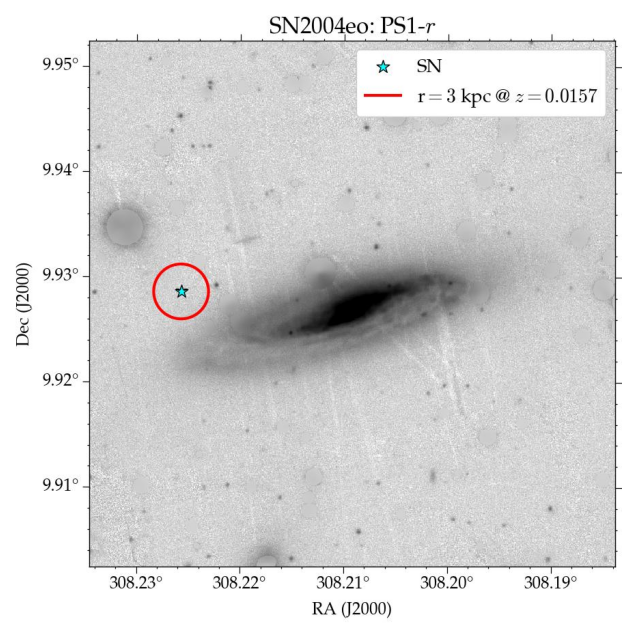

In [11]:
plot_image('images/SN2004eo/PS1/local_PS1_r_3kpc.jpg')

The star marks the position of the SN and the red circle the aperture used.

### Global Photometry

Global photometry relies on `sep <https://github.com/kbarbary/sep/>`_ and uses `Kron fluxes`. It works in a relatively similar way to the local photometry:

In [12]:
from hostphot.photometry import global_photometry as gp

results = gp.multi_band_phot(name, host_ra, host_dec,
                             survey=survey, ra=ra, dec=dec,
                             use_mask=True, correct_extinction=True,
                             common_aperture=True, ref_filt='riz',
                             save_aperture_params=False,
                             save_plots=True)

In [13]:
results

,name,host_ra,host_dec,survey,g,g_err,g_flux,g_flux_err,g_zeropoint,r,...,z,z_err,z_flux,z_flux_err,z_zeropoint,y,y_err,y_flux,y_flux_err,y_zeropoint
0,SN2004eo,308.2092,9.92755,PS1,12.558798,0.014012,94728.561494,899.796095,25.0,11.842767,...,11.237708,0.015005,319828.143739,3889.753061,25.0,10.915586,0.018016,430294.131938,6417.382266,25.0


Setting ``common_aperture=True`` tells HostPhot to used the same aperture for all the filters, obtained from the coadded image (``coadd_filters='riz'``; see :ref:`Image Pre-processing <preprocessing>`) and setting ``optimize_kronrad=True`` provides a more "reliable" aperture than using the default parameters commonly used by SExtractor, as the aperture is increased until the change in flux is samller than a given percent (this can be changed with ``eps``). The rest of the parameters are the same as before.

Image with **global** aperture:

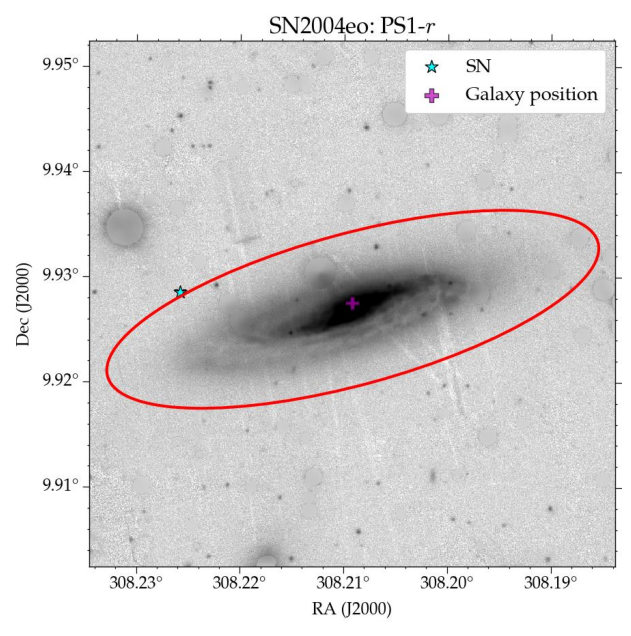

In [14]:
plot_image('images/SN2004eo/PS1/global_PS1_r.jpg')

The parameters ``ra`` and ``dec`` are only used to plot the position of the SN. By default, HostPhot corrects for Milky Way extinction using the recalibrated dust maps by Schlafly & Finkbeiner (2011) and the extinction law from Fitzpatrick (1999).

In [15]:
results2 = gp.multi_band_phot(name, host_ra, host_dec,
                              survey=survey, ra=ra, dec=dec,
                              use_mask=True, correct_extinction=True,
                              common_aperture=False,
                              save_plots=False)

In [16]:
results2

,name,host_ra,host_dec,survey,g,g_err,g_flux,g_flux_err,g_zeropoint,r,...,z,z_err,z_flux,z_flux_err,z_zeropoint,y,y_err,y_flux,y_flux_err,y_zeropoint
0,SN2004eo,308.2092,9.92755,PS1,12.558012,0.014011,94797.140406,900.383686,25.0,11.840919,...,11.238792,0.015004,319509.126296,3885.795633,25.0,10.917236,0.018016,429640.956734,6407.733834,25.0


In [17]:
results == results2

,name,host_ra,host_dec,survey,g,g_err,g_flux,g_flux_err,g_zeropoint,r,...,z,z_err,z_flux,z_flux_err,z_zeropoint,y,y_err,y_flux,y_flux_err,y_zeropoint
0,True,True,True,True,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
